In [184]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys

# Change root directory to the repo root (Jupyter: __file__ is not defined)
def find_repo_root(start=Path.cwd()):
	for p in [start] + list(start.parents):
		if (p / 'Code').exists() or (p / '.git').exists() or (p / 'local_repo').exists():
			return p
	return start

repo_root = find_repo_root()
data_root = repo_root.parent.parent / 'Data' / 'CBOS ready'

In [185]:
# Load cleaned data
df = pd.read_csv(data_root / 'CBOS_data_cleaned.csv')
df_loaded = df

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_66292/793611774.py:2: DtypeWarning: Columns (14,15,20,21,22,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_root / 'CBOS_data_cleaned.csv')


In [186]:
files = set(df_loaded['survey file'].values)

# sort them by the number in the file name
files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [187]:
# Gini coefficient
def gini_coefficient(x):
    n = len(x)
    if n == 0:
        return np.nan
    cumulative_x = np.cumsum(np.sort(x))
    sum_x = cumulative_x[-1]
    if sum_x == 0:
        return 0.0
    gini = (n + 1 - 2 * np.sum(cumulative_x) / sum_x) / n
    return gini

# Palma ratio
def palma_ratio(x):
    n = len(x)
    if n == 0:
        return np.nan
    sorted_x = np.sort(x)
    bottom_40 = np.sum(sorted_x[:int(0.4 * n)])
    top_10 = np.sum(sorted_x[int(0.9 * n):])
    if bottom_40 == 0:
        return np.nan
    palma = top_10 / bottom_40
    return palma

In [188]:
# Let's check the means of income_hh
means = []
means_total = []
w_means_total = []
ginis = []
palmas = []
dates = []
for file in files:
    df_file = df_loaded[df_loaded['survey file'] == file]
    year = df_file['survey year'].values[0]
    month = df_file['survey month'].values[0]
    # Create a date of the pandas datetime type
    date = pd.to_datetime(f"{year}-{month}-01")
    dates.append(date)
    income_hh_values = pd.to_numeric(df_file['income_hh'], errors='coerce')
    weights = pd.to_numeric(df_file['weight'], errors='coerce')
    # Remove values > 99991
    if year < 2001:
        weights = weights[income_hh_values <= 9991]
        income_hh_values = income_hh_values[income_hh_values <= 9991]    
    else:
        weights = weights[income_hh_values <= 99991]
        income_hh_values = income_hh_values[income_hh_values <= 99991]
    # Negative values to NaN
    weights = weights[income_hh_values >= 0]
    income_hh_values = income_hh_values[income_hh_values >= 0]
    # Remove NaN values
    weights = weights[~np.isnan(income_hh_values)]
    income_hh_values = income_hh_values[~np.isnan(income_hh_values)]
    # for means total mulitpy by household size
    income_hh_total_values = income_hh_values * pd.to_numeric(df_file['household_size'], errors='coerce')
    weights_total = weights[~np.isnan(income_hh_total_values)]
    income_hh_total_values = income_hh_total_values[~np.isnan(income_hh_total_values)]
    
    mean_income_hh_total = income_hh_total_values.mean()
    means_total.append(mean_income_hh_total)
    mean_income_hh = income_hh_values.mean()
    means.append(mean_income_hh)
    
    # Weighted mean
    if weights_total.sum() == 0:
        w_mean_income_hh_total = np.nan
        w_means_total.append(w_mean_income_hh_total)
    else:    
        w_mean_income_hh_total = np.average(income_hh_total_values, weights=weights_total)
        w_means_total.append(w_mean_income_hh_total)
    
    
    gini_income_hh = gini_coefficient(income_hh_values.values)
    if gini_income_hh > 0:
        ginis.append(gini_income_hh)
    else:
        ginis.append(np.nan)
    palma_income_hh = palma_ratio(income_hh_values.values)
    palmas.append(palma_income_hh)
    print(f"Mean income_hh for {file}: {mean_income_hh}")

Mean income_hh for CBOS_1_01_1990.sav: 22.47962835512732
Mean income_hh for CBOS_2_02_1990.sav: 30.729680054458818
Mean income_hh for CBOS_3_03_1990.sav: 32.66423208191126
Mean income_hh for CBOS_4_04_1990.sav: 34.30044378698225
Mean income_hh for CBOS_5_05_1990.sav: 34.112869924294564
Mean income_hh for CBOS_6_06_1990.sav: 35.78622589531681
Mean income_hh for CBOS_7_07_1990.sav: 0.0
Mean income_hh for CBOS_8_09_1990.sav: 0.0
Mean income_hh for CBOS_9_10_1990.sav: 0.0
Mean income_hh for CBOS_10_11_1990.sav: 0.0
Mean income_hh for CBOS_11_12_1990.sav: 0.0
Mean income_hh for CBOS_12_01_1991.sav: 0.0
Mean income_hh for CBOS_13_02_1991.sav: 0.0
Mean income_hh for CBOS_14_03_1991.sav: 0.0
Mean income_hh for CBOS_15_04_1991.sav: 0.0
Mean income_hh for CBOS_16_05_1991.sav: 0.0
Mean income_hh for CBOS_17_06_1991.sav: 0.0
Mean income_hh for CBOS_18_07_1991.sav: 0.0
Mean income_hh for CBOS_19_08_1991.sav: 0.0
Mean income_hh for CBOS_20_09_1991.sav: 0.0
Mean income_hh for CBOS_21_10_1991.sav: 0.0

In [189]:
import matplotlib.pyplot as plt

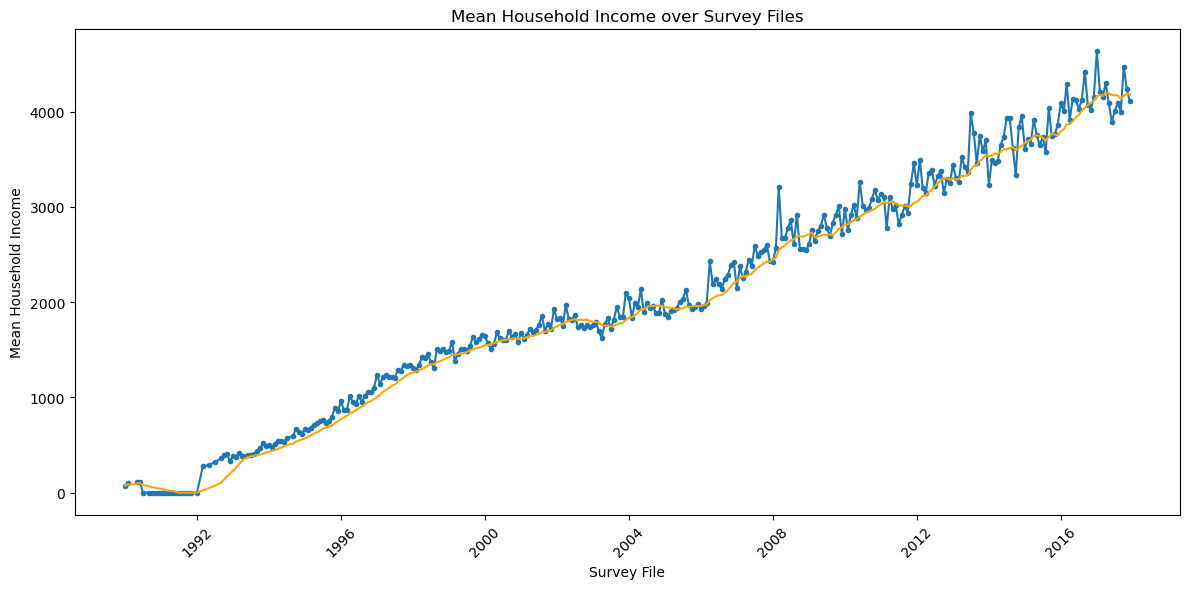

In [190]:
# plot means over time

plt.figure(figsize=(12, 6))
plt.plot(dates, means_total, marker='.')
# Moveing average with window size 3
roll_ave= pd.Series(means_total).rolling(window=12, min_periods=1).mean()
plt.plot(dates, roll_ave, label='3-point Moving Average', color='orange')
plt.xticks(rotation=45)
#plt.ylim(0, max(palmas)*1.1)
plt.xlabel('Survey File')
plt.ylabel('Mean Household Income')
plt.title('Mean Household Income over Survey Files')
plt.tight_layout()
plt.show()

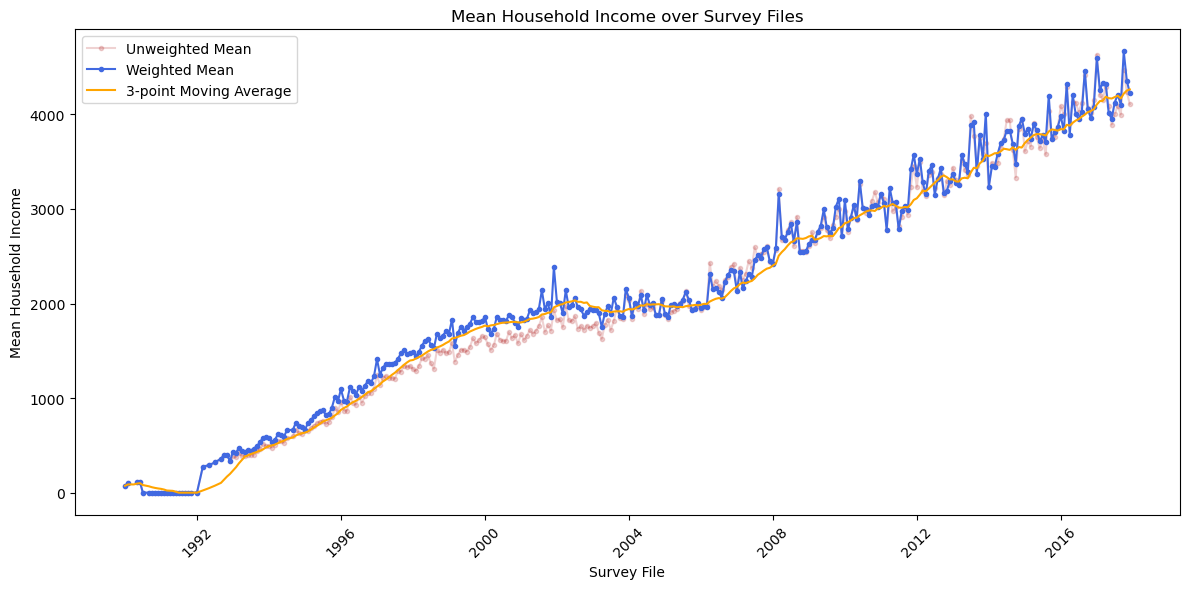

In [191]:
# plot weighted means over time

plt.figure(figsize=(12, 6))
plt.plot(dates, means_total, marker='.', alpha=0.2, color='firebrick', label='Unweighted Mean')
plt.plot(dates, w_means_total, marker='.', color='royalblue', label='Weighted Mean')
# Moveing average with window size 3
roll_ave= pd.Series(w_means_total).rolling(window=12, min_periods=1).mean()
plt.plot(dates, roll_ave, label='3-point Moving Average', color='orange')
plt.xticks(rotation=45)
#plt.ylim(0, max(palmas)*1.1)
plt.xlabel('Survey File')
plt.ylabel('Mean Household Income')
plt.title('Mean Household Income over Survey Files')
plt.legend()
plt.tight_layout()
plt.show()

In [192]:
df

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
0,1.0,CBOS_1_01_1990.sav,1990,1,0,1957.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
1,2.0,CBOS_1_01_1990.sav,1990,1,0,1950.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
2,3.0,CBOS_1_01_1990.sav,1990,1,0,1932.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
3,4.0,CBOS_1_01_1990.sav,1990,1,0,1946.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
4,5.0,CBOS_1_01_1990.sav,1990,1,0,1939.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358520,921.0,CBOS_331_12_2017.sav,2017,12,0,1957.0,1.0,Mężczyzna,1.0,wieś,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,0.611965
358521,922.0,CBOS_331_12_2017.sav,2017,12,0,1981.0,1.0,Mężczyzna,1.0,wieś,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.127158
358522,923.0,CBOS_331_12_2017.sav,2017,12,0,1976.0,1.0,Mężczyzna,5.0,miasto od 100 000 do 499 999,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.716070
358523,924.0,CBOS_331_12_2017.sav,2017,12,0,1971.0,2.0,Kobieta,5.0,miasto od 100 000 do 499 999,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.572886


In [193]:
# Generally mask out values greater than 99991

mask = df['income_hh'] > 99991
# Change the income_hh values greater than 99991 to NaN
for idx, value in df.loc[mask, 'income_hh'].items():
    df.at[idx, 'income_hh'] = np.nan
    
# For years before 2001, mask out values greater than 9991
mask = (df['survey year'] < 2001) & (df['income_hh'] > 9991)
# Change the income_hh values greater than 9991 to NaN
for idx, value in df.loc[mask, 'income_hh'].items():
    df.at[idx, 'income_hh'] = np.nan
    
# The same for income_hh_OLD and income_hh_NEW
mask_old = (df['survey year'] < 2001) & (df['income_hh_OLD'] > 9991)
for idx, value in df.loc[mask_old, 'income_hh_OLD'].items():
    df.at[idx, 'income_hh_OLD'] = np.nan

mask_old = (df['survey year'] >= 2001) & (df['income_hh_OLD'] > 99991)
for idx, value in df.loc[mask_old, 'income_hh_OLD'].items():
    df.at[idx, 'income_hh_OLD'] = np.nan

mask_new = (df['survey year'] < 2001) & (df['income_hh_NEW'] > 9991)
for idx, value in df.loc[mask_new, 'income_hh_NEW'].items():
    df.at[idx, 'income_hh_NEW'] = np.nan

mask_new = (df['survey year'] >= 2001) & (df['income_hh_NEW'] > 99991)
for idx, value in df.loc[mask_new, 'income_hh_NEW'].items():
    df.at[idx, 'income_hh_NEW'] = np.nan


In [ ]:
# CBOS 7 to CBOS 23 contains only zeroes in income_hh and income_hh_OLD
# For these files, we have treshold data.

files = set(df['survey file'].values)
files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))

mask = df['survey file'].isin(files[6:23])

display(df[mask])






,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
8837,1.0,CBOS_7_07_1990.sav,1990,7,0,1949.0,2.0,Kobieta,1.0,wsią,...,NaN,NaN,NaN,3.0,0,3.0,601 - 900 tys. zł.,NaN,601 - 900 tys. zł.,1.0
8838,2.0,CBOS_7_07_1990.sav,1990,7,0,1934.0,1.0,Mężczyzna,1.0,wsią,...,NaN,NaN,NaN,2.0,0,2.0,301 - 600 tys. zł.,NaN,301 - 600 tys. zł.,1.0
8839,3.0,CBOS_7_07_1990.sav,1990,7,0,1957.0,2.0,Kobieta,1.0,wsią,...,NaN,NaN,NaN,2.0,0,2.0,301 - 600 tys. zł.,NaN,301 - 600 tys. zł.,1.0
8840,4.0,CBOS_7_07_1990.sav,1990,7,0,1957.0,1.0,Mężczyzna,1.0,wsią,...,NaN,NaN,NaN,4.0,0,4.0,901 - 1.200 tys. zł.,NaN,901 - 1.200 tys. zł.,1.0
8841,5.0,CBOS_7_07_1990.sav,1990,7,0,1953.0,1.0,Mężczyzna,3.0,miastem: od 20 do 100 tys. mieszkańców,...,NaN,NaN,NaN,4.0,0,4.0,901 - 1.200 tys. zł.,NaN,901 - 1.200 tys. zł.,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30671,996.0,CBOS_23_01_1992.sav,1992,1,0,1918.0,1.0,Mężczyzna,3.0,od 20 do 100 tys mieszkańców,...,NaN,NaN,NaN,2.0,0,2.0,751 - 1.500 tys. zł,NaN,751 - 1.500 tys. zł,1.0
30672,997.0,CBOS_23_01_1992.sav,1992,1,0,1924.0,1.0,Mężczyzna,5.0,501 tys mieszkańców lub więcej,...,NaN,NaN,NaN,2.0,0,2.0,751 - 1.500 tys. zł,NaN,751 - 1.500 tys. zł,1.0
30673,998.0,CBOS_23_01_1992.sav,1992,1,0,1926.0,1.0,Mężczyzna,5.0,501 tys mieszkańców lub więcej,...,NaN,NaN,NaN,3.0,0,3.0,1.501 do 2.500 tys. zł,NaN,1.501 do 2.500 tys. zł,1.0
30674,999.0,CBOS_23_01_1992.sav,1992,1,0,1926.0,1.0,Mężczyzna,4.0,od 101 do 500 tys mieszkańców,...,NaN,NaN,NaN,2.0,0,2.0,751 - 1.500 tys. zł,NaN,751 - 1.500 tys. zł,1.0


In [194]:
# Save the final data
df.to_csv(data_root / 'CBOS_data_final.csv', index=False)

In [195]:
# Bottom 50% mean income_hh
# 50-90% mean income_hh
# Upper 10% mean income_hh

bottom_50_means = []
middle_40_means = []
upper_10_means = []

for file in files:
    df_file = df_loaded[df_loaded['survey file'] == file]
    income_hh_values = pd.to_numeric(df_file['income_hh'], errors='coerce')
    weights = pd.to_numeric(df_file['weight'], errors='coerce')
    
    # compute total income for households
    income_hh_values = income_hh_values * pd.to_numeric(df_file['household_size'], errors='coerce')
    
    # Compute the weighted income values
    weighted_income = income_hh_values * weights
    
    # Remove NaN values
    weighted_income = weighted_income[~np.isnan(weighted_income)]
    
    # Sort the weighted income values
    sorted_income = np.sort(weighted_income)
    
    # Bottom 50%
    bottom_50 = sorted_income[:int(0.5 * len(sorted_income))]
    bottom_50_mean = bottom_50.mean()
    bottom_50_means.append(bottom_50_mean)
    
    # Middle 40%
    middle_40 = sorted_income[int(0.5 * len(sorted_income)):int(0.9 * len(sorted_income))]
    middle_40_mean = middle_40.mean()
    middle_40_means.append(middle_40_mean)
    
    # Upper 10%
    upper_10 = sorted_income[int(0.9 * len(sorted_income)):]
    upper_10_mean = upper_10.mean()
    upper_10_means.append(upper_10_mean)

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_66292/3390356424.py:28: RuntimeWarning: Mean of empty slice.
  bottom_50_mean = bottom_50.mean()
/Users/jedrek/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_66292/3390356424.py:33: RuntimeWarning: Mean of empty slice.
  middle_40_mean = middle_40.mean()
/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_66292/3390356424.py:38: RuntimeWarning: Mean of empty slice.
  upper_10_mean = upper_10.mean()


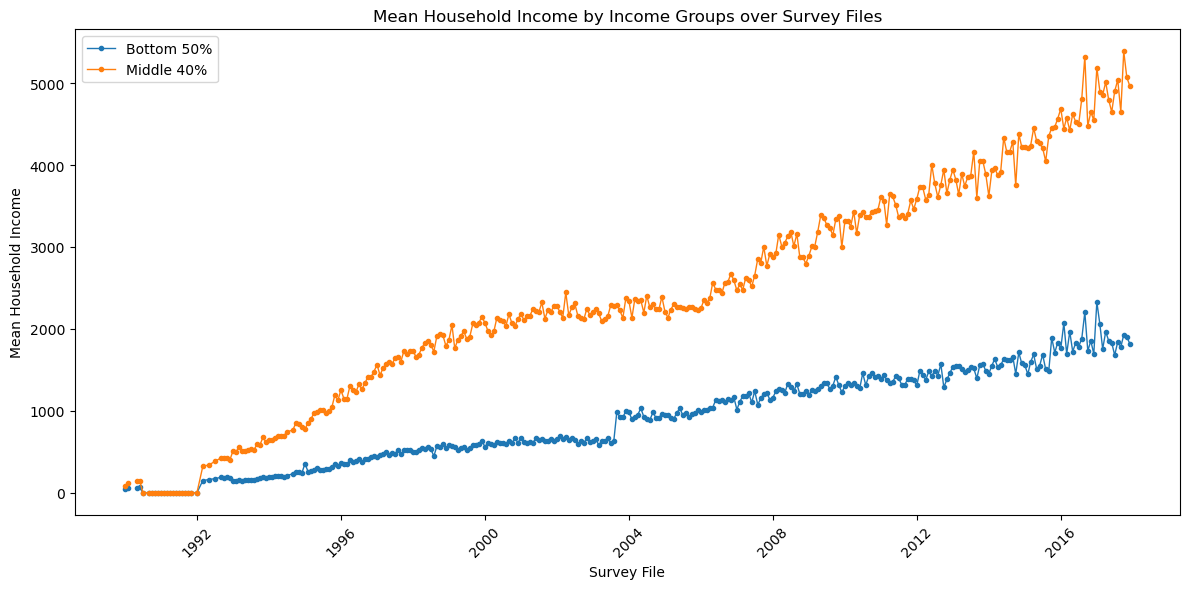

In [196]:
# plot means over time

plt.figure(figsize=(12, 6))
plt.plot(dates, bottom_50_means, marker='.', label='Bottom 50%', linewidth=1)
plt.plot(dates, middle_40_means, marker='.', label='Middle 40%', linewidth=1)
#plt.plot(dates, upper_10_means, marker='.', label='Upper 10%', linewidth=1)
plt.xticks(rotation=45)
#plt.ylim(0, 19000)
plt.xlabel('Survey File')
plt.ylabel('Mean Household Income')
plt.title('Mean Household Income by Income Groups over Survey Files')
plt.legend()
plt.tight_layout()
plt.show()

In [197]:
# Loading inflation data (try multiple encodings to avoid UnicodeDecodeError)
inflation_path = data_root.parent / 'Auxiliary data' / 'inflation_data.csv'
try:
	inflation_data_org = pd.read_csv(inflation_path, encoding='utf-8', sep=";")
except UnicodeDecodeError:
	try:
		inflation_data_org = pd.read_csv(inflation_path, encoding='latin-1', sep=";")
	except UnicodeDecodeError:
		inflation_data_org = pd.read_csv(inflation_path, encoding='cp1250', sep=";")

In [198]:
v_contains = np.vectorize(lambda x,y: x in y)
v_replace = np.vectorize(lambda x,y,z: x.replace(y,z))

In [199]:
inflation_data_org = inflation_data_org[v_contains("Poprzedni miesi¹c = 100", inflation_data_org['Sposób prezentacji'].values)]

In [200]:
inflation_data = pd.Series(data= pd.to_numeric(v_replace(inflation_data_org['Wartoæ'], ",", "."), errors='coerce'),
                           index= pd.to_datetime(inflation_data_org['Rok'].astype(str) + '-' + inflation_data_org['Miesi¹c'].astype(str) + '-01', format='%Y-%m-%d'))

# Save cleaned inflation data
inflation_data.to_csv(data_root.parent / 'Auxiliary data' / 'inflation_data_cleaned.csv', header=['inflation_index'])

In [201]:
inflation_data_org

,Nazwa zmiennej,Jednostka terytorialna,Sposób prezentacji,Rok,Miesi¹c,Wartoæ,Flaga,Unnamed: 7,Unnamed: 8
12,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,2025,1,"101,0",NaN,NaN,NaN
13,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,2025,2,"100,3",NaN,NaN,NaN
14,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,2025,3,"100,2",NaN,NaN,NaN
15,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,2025,4,"100,4",NaN,NaN,NaN
16,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,2025,5,"99,8",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2107,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,1982,8,"99,4",NaN,NaN,NaN
2108,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,1982,9,"100,3",NaN,NaN,NaN
2109,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,1982,10,"101,4",NaN,NaN,NaN
2110,Wskanik cen towarów i us³ug konsumpcyjnych,Polska,Poprzedni miesi¹c = 100,1982,11,"100,9",NaN,NaN,NaN


In [202]:
# inflation data is monthly index with values like 102.5 meaning 2.5% inflation
inflation_rate_data = inflation_data - 100